In [1]:
import numpy as np
import os
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
os.chdir('../')

In [3]:
df_train = pd.read_csv('./data/processed/train.csv', sep = ';', decimal=',')

In [4]:
df_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,date
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,2017-01-08
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,2017-01-08


In [5]:
center_id = 55
meal_id = 1993

condition1 = df_train['center_id'] == center_id
condition2 = df_train['meal_id'] == meal_id

In [6]:
df_train_processed = df_train[condition1 & condition2]

In [7]:
df_train_processed.date = pd.date_range('2017-01-01', periods=len(df_train_processed), freq='W')

In [8]:
df_train_processed['day'] = df_train_processed.date.dt.day
df_train_processed['month'] = df_train_processed.date.dt.month
df_train_processed['year'] = df_train_processed.date.dt.year
df_train_processed['quarter'] = df_train_processed.date.dt.quarter

In [9]:
df_train_processed.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,date,day,month,year,quarter
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-01,1,1,2017,1
2923,1035555,2,55,1993,133.89,133.89,0,0,121,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08,8,1,2017,1
5819,1282652,3,55,1993,134.86,133.86,0,0,258,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-15,15,1,2017,1
8718,1066744,4,55,1993,134.89,133.89,0,0,82,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-22,22,1,2017,1
11607,1115779,5,55,1993,147.50,145.50,0,0,81,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-29,29,1,2017,1


In [10]:
df_train_processed = df_train_processed.drop(columns=['id', 'center_id', 'meal_id', 'center_type', 'category', 'cuisine'])

In [11]:
df_train_processed = df_train_processed.set_index('date')

In [12]:
df_train_processed.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,day,month,year,quarter
date,,,,,,,,,,,,,
2017-01-01,1,136.83,135.83,0,0,270,647,56,2.0,1,1,2017,1
2017-01-08,2,133.89,133.89,0,0,121,647,56,2.0,8,1,2017,1
2017-01-15,3,134.86,133.86,0,0,258,647,56,2.0,15,1,2017,1
2017-01-22,4,134.89,133.89,0,0,82,647,56,2.0,22,1,2017,1
2017-01-29,5,147.50,145.50,0,0,81,647,56,2.0,29,1,2017,1


In [13]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2017-01-01 to 2019-10-06
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   week                   145 non-null    int64  
 1   checkout_price         145 non-null    float64
 2   base_price             145 non-null    float64
 3   emailer_for_promotion  145 non-null    int64  
 4   homepage_featured      145 non-null    int64  
 5   num_orders             145 non-null    int64  
 6   city_code              145 non-null    int64  
 7   region_code            145 non-null    int64  
 8   op_area                145 non-null    float64
 9   day                    145 non-null    int64  
 10  month                  145 non-null    int64  
 11  year                   145 non-null    int64  
 12  quarter                145 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 15.9 KB


In [14]:
X = df_train_processed.drop(columns='num_orders')
Y = np.log1p(df_train_processed['num_orders'])

In [15]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
split_size = len(df_train_processed)-15
X_train = X.iloc[:split_size,:]
X_test = X.iloc[split_size:,:]
Y_train =  Y.iloc[:split_size]
Y_test = Y.iloc[split_size:]

In [16]:
import plotly.express as px
import plotly.graph_objects as go

In [17]:
fig = go.Figure()

fig.add_trace(
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		mode = 'lines',
		name = 'train'
	)
)

fig.add_trace(
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		mode = 'lines',
		name = 'test'
	)
)

fig.show()

# XGBoost

In [18]:
model = xgb.XGBRegressor(
	learning_rate = 0.01,
	eval_metric ='rmse',
	n_estimators = 50000,
	max_depth = 5,
	subsample = 0.8,
	colsample_bytree = 1,
	gamma = 0.5  
 )

In [19]:
model.fit(
	X_train,
	Y_train,
	eval_metric='rmse',
	eval_set=[(X_test, Y_test)],
	early_stopping_rounds=500,
	verbose=0
)

[23:14:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
       gamma=0.5, importance_type='gain', learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=50000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [20]:
best = model.get_booster().best_iteration

In [21]:
xgb_model = xgb.XGBRegressor(
	learning_rate = 0.01,
	n_estimators = best,
	max_depth = 5,
	subsample = 0.8,
	colsample_bytree = 1,
	gamma = 0.5
)

In [22]:
xgb_model.fit(X_train, Y_train)

[23:14:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=336,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [23]:
xgb_preds = xgb_model.predict(X_test)

In [24]:
xgb_preds = np.exp(xgb_preds)

In [25]:
xgb_preds = pd.DataFrame(xgb_preds)
xgb_preds.index = Y_test.index

In [26]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [27]:
mse=metrics.mean_squared_error(Y_test, xgb_preds)
print('RMSE: ' + str(np.sqrt(mse)))

RMSE: 45.64661768763348


In [28]:
import matplotlib.pyplot as plt

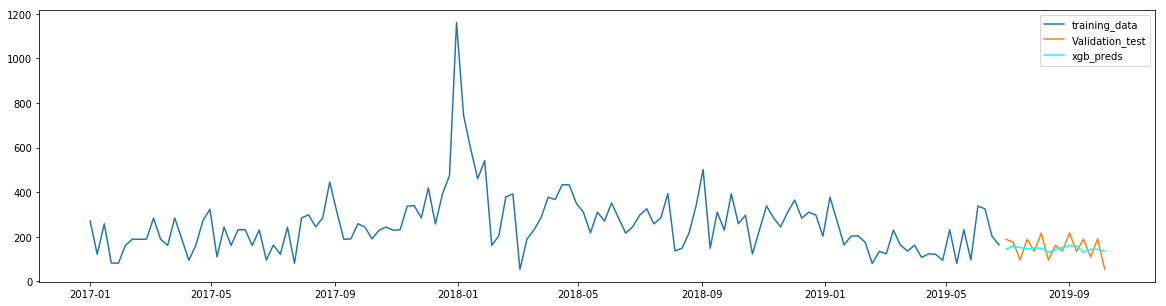

In [29]:
plt.figure(figsize=(20,5))
plt.plot(Y_train.sort_index(), label='training_data')
plt.plot(Y_test.sort_index(), label='Validation_test')
plt.plot(xgb_preds.sort_index(), color='cyan', label='xgb_preds')
plt.legend(loc='best')

# Linear Regression

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train = X.iloc[:split_size,:]
X_test = X.iloc[split_size:,:]
Y_train =  Y.iloc[:split_size]
Y_test = Y.iloc[split_size:]

In [34]:
lr = LinearRegression()  
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
y_pred = lr.predict(X_test)


In [36]:
y_train = np.exp(Y_train)
y_pred = np.exp(y_pred)

In [38]:
print('Root Mean Squared Error for LinearRegression:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Root Mean Squared Error for LinearRegression: 223.6411129399292


In [40]:
lm_preds = pd.DataFrame(y_pred)
lm_preds.index = Y_test.index

In [44]:
fig = go.Figure()

fig.add_trace(
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		mode = 'lines',
		name = 'train'
	)
)

fig.add_trace(
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		mode = 'lines',
		name = 'test'
	)
)

fig.add_trace(
	go.Scatter(
		x = lm_preds.index,
		y = lm_preds,
		mode = 'lines',
		name = 'XGBoost'
	)
)

fig.show()